In [90]:
import json
import os
import os.path as osp
from glob import glob
from PIL import Image

from tqdm import tqdm

from torch.utils.data import DataLoader, ConcatDataset, Dataset

import xml.etree.ElementTree as ET
import re

In [2]:
lang_dirs = ['English', 'Korean', 'Mixed']
cam_dirs = ['Digital_Camera', 'Mobile_Phone']

SRC_DATASET_DIR = '/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST'  # 파일 위치
DST_DATASET_DIR = '/opt/ml/input/data/KAIST_SceneText'  # 선택한 파일 저장 위치

NUM_WORKERS = 4  # FIXME

IMAGE_EXTENSIONS = {'.gif', '.jpg', '.png', '.JPG'}

In [3]:
def maybe_mkdir(x):
    if not osp.exists(x):
        os.makedirs(x)

In [255]:
def get_paths(image_dir):
    path_images = []
    path_labels = []
    namelist = []
    N_samename = 0

    for lang_dir in lang_dirs:          # for language dir
        for cam_dir in cam_dirs:        # for camera type dir
            sub_dirs = glob(osp.join(image_dir, lang_dir, cam_dir, '*.zip'))
            for sub_dir in sub_dirs:
                all_files = glob(osp.join(sub_dir[:-4], '*'))
                bmp_files = glob(osp.join(sub_dir[:-4], '*.bmp'))
                
                for name in bmp_files:
                    name = name[:-4]
                    # ! 중복된 이름의 파일은 추가하지 않았습니다. 데이터 손실. 나중에 수정 필요
                    purename = osp.basename(name)
                    if purename in namelist:
                        N_samename += 1
                        continue
                    else:
                        namelist.append(purename)
                    
                    # jpg JPG xml None
                    # image path
                    if os.path.isfile(name + '.jpg'):
                        path_images.append(name + '.jpg')
                    elif os.path.isfile(name + '.JPG'):
                        path_images.append(name + '.JPG')
                    else:
                        assert False, 'no jpg file'
                    # xml path
                    if os.path.isfile(name + '.xml'):
                        path_labels.append(name + '.xml')
                    elif os.path.isfile(name):
                        path_labels.append(name)
                    else:
                        assert False, 'no xml file'            
    
    print('========= get_paths =========')
    print('N path_images', len(path_images))
    print('N path_labels', len(path_labels))
    print('N namelist', len(namelist))
    print('N samename', N_samename)
    print('=============================')
    
    return path_images, path_labels

In [256]:
class KAISTSceneTextDataset(Dataset):
    def __init__(self, image_dir, copy_images_to):
        # get paths
        image_paths, label_paths = get_paths(image_dir)
        assert len(image_paths) == len(label_paths)

        sample_ids, samples_info = list(), dict()
        errorous_files = []
        for image_path, label_path in zip(image_paths, label_paths):
            # check label & image path pair
            sample_id = osp.splitext(osp.basename(image_path))[0]    # ('00510012043', '.jpg')
            assert osp.splitext(osp.basename(image_path))[1], image_path
            assert osp.splitext(osp.basename(image_path))[0] == osp.splitext(osp.basename(label_path))[0]
            
            # get word dict
            try:
                words_info, image_info = self.parse_label_file(label_path)
                sample_ids.append(sample_id)
                samples_info[sample_id] = dict(image_path=image_path, label_path=label_path,
                                               words_info=words_info, image_info=image_info)
            except:
                errorous_files.append(image_path)
        print('fail files: ', errorous_files)

        self.sample_ids, self.samples_info = sample_ids, samples_info

        self.copy_images_to = copy_images_to

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sample_info = self.samples_info[self.sample_ids[idx]]

        image_fname = osp.basename(sample_info['image_path'])
        image = Image.open(sample_info['image_path'])
        img_w, img_h = image.size

        if self.copy_images_to:
            maybe_mkdir(self.copy_images_to)
            savepath = osp.join(self.copy_images_to, osp.basename(sample_info['image_path']))
            if os.path.isfile(savepath): 
                assert False, 'already file exists' + osp.basename(sample_info['image_path'])
            image.save(savepath)

        # difficulty tag
        tags = ['D' + sample_info['image_info']['difficulty']]
        if sample_info['image_info']['illumination'] == 'yes':
            tags.append('non_uniform_illumination')

        license_tag = dict()
        sample_info_ufo = dict(img_h=img_h, img_w=img_w, words=sample_info['words_info'], tags=tags,
                               license_tag=license_tag)

        return image_fname, sample_info_ufo

    def parse_label_file(self, label_path):
        re_ko = re.compile('[ㄱ-ㅣ가-힣]')
        re_en = re.compile('[a-zA-Z]')
        
        label = ET.parse(label_path)
        # "images"-"image"-{"imageName","resolution", "words", "illumination", "difficulty"}
        img = label.getroot().find("image")
        img_name = img.find("imageName").text               # DSC04200.JPG
        img_illumination = img.find("illumination").text    # no  [yes, no]
        img_difficulty = img.find("difficulty").text        # 3   [1,2,3,4,5]
        image_info = dict(name=img_name, illumination=img_illumination, difficulty=img_difficulty)
       
        words_info = dict()             # words_info, languages = dict(), set()
        img_words = img.find("words")
        Num = 0
        for word in img_words:
            # word.attrib = {'x': '114', 'y': '266', 'width': '409', 'height': '119'}
            # points
            x = float(word.get('x')); y = float(word.get('y'))
            w = float(word.get('width')); h = float(word.get('height'))
            points = [[x, y], [x+w, y], [x+w, y+h], [x, y+h]]
            # transcription
            transcription = ''
            languagelist = []
            for cha in word:
                transcription += cha.get('char')
            # language
            languagelist = []
            if re_ko.search(transcription):
                languagelist.append('ko')
            if re_en.search(transcription):
                languagelist.append('en')
            # illegibility
            illegibility = False
            # orientation
            orientation = 'Horizontal'     # 정보가 없어서 임의로 넣음. 실제로는 vertical 존재
            # word_tags
            word_tags = None
            words_info[Num] = dict(
               points=points, transcription=transcription, language=languagelist,
                illegibility=illegibility, orientation=orientation, word_tags=word_tags
            )
            Num += 1
        
        return words_info, image_info

In [260]:
dataset = KAISTSceneTextDataset(SRC_DATASET_DIR,
                                copy_images_to=osp.join(DST_DATASET_DIR, 'images'))

anno = dict(images=dict())
with tqdm(total=len(dataset)) as pbar:
    for batch in DataLoader(dataset, num_workers=NUM_WORKERS, collate_fn=lambda x: x):
        image_fname, sample_info = batch[0]
        anno['images'][image_fname] = sample_info
        pbar.update(1)

ufo_dir = osp.join(DST_DATASET_DIR, 'ufo')
maybe_mkdir(ufo_dir)
with open(osp.join(ufo_dir, 'AIHub_Docs.json'), 'w') as f:
    json.dump(anno, f, indent=4)

========= get_paths =========
N path_images 2388
N path_labels 2388
N namelist 2388
N samename 95
fail files:  ['/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/English/Digital_Camera/(E.S)C-outdoor1/080116-0055.jpg', '/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/English/Digital_Camera/(E.S)C-outdoor1/080116-0089.jpg', '/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/English/Digital_Camera/(E.S)F-others/4.jpg', '/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/Korean/Digital_Camera/G-others/080116-0079.jpg', '/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/Korean/Digital_Camera/E-night/3.jpg', '/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/Korean/Digital_Camera/indoor1/080119-0001.jpg']


100%|██████████| 2382/2382 [00:05<00:00, 456.56it/s]


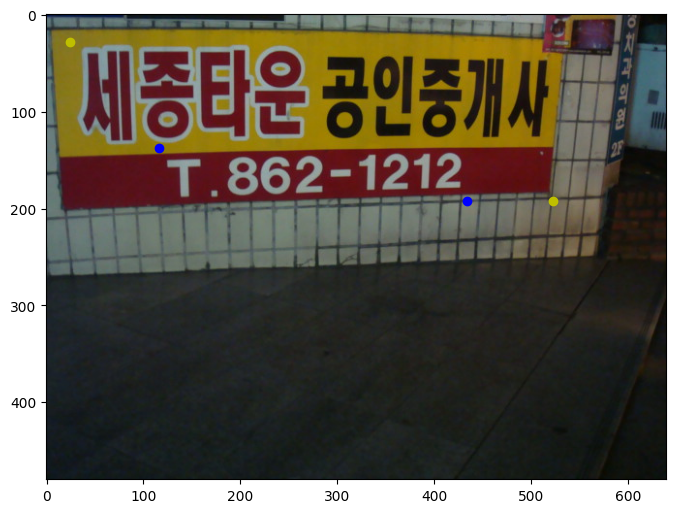

In [170]:
import matplotlib.pyplot as plt
import matplotlib.image as img
plt.figure(figsize=(8,8))
img_test = img.imread('/opt/ml/input/originals/KAIST_SceneTextDatabase/KAIST/Mixed/Digital_Camera/(C.S)A-shadow/DSC02567.JPG')
plt.scatter(24, 28, c='y')
plt.scatter(24+499, 28+164, c='y')
plt.scatter(116, 138, c='b')
plt.scatter(116+318, 138+54, c='b')
plt.imshow(img_test)
plt.show()

In [254]:
os.path.isfile('/opt/ml/input/data/ICDAR17_Korean/ufo/train.jsn')

False